# Example Design Note for Jupyter

# 1. General

## 1.1 Project information
**Project number:**  
**Project name:**  
**Date:**  
**Engineer:**  
**Checker:**  

## 1.2 Purpose of calculations

Describe the particular use to which the design note is put on this occasion.

## 1.3 Design note
**Name of design note:** Simple reinforced concrete beam  
**Version:** PA  
**Last modified:** 2023-07-28  
**Custodian:** MPJ Grégoire, ing.

This design note checks ultimate and serviceability limit states for a single span reinforced concrete beam loaded with a live load at the midspan.

## 1.4 Citations

Citations such as §, Fig. and Tab. are to the Canadian Highway Bridge Design Code or to its Commentary, unless noted otherwise.

## 1.5 References

### 1.5.1 Normative
- CAN/CSA S6:19, Canadian Highway Bridge Design Code, CSA, 2019
- CAN/CSA S6.1:19, Commentary on the Canadian Highway Bridge Design Code, CSA, 2019

### 1.5.2 Informative
- Manuel de conception des structures, MTQ

### 1.5.3 Drawings
- none

## 1.6 Assumptions
1. Plane sections remain plane

## 1.7 To do:
- Add comparison with M_r
- Add check for over-reinforcement
- Add ULS check for shear
- Add SLS check for cracking
- Add development length for longitudinal bars, effective A_s
- Maybe add SLS check for deflection
- Fix calculation for deflection under point load
- Add more citations maybe

**This design note is not a substitute for engineering judgement.**

# 2. Initialisation

In [1]:
from math import sqrt, pi
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:" " .2f}'.format  # TODO spaces not commas

import pint
ureg = pint.UnitRegistry()
ureg.default_format = '~'
Q_ = ureg.Quantity
ureg.setup_matplotlib(True)

import pint_pandas
pint_pandas.PintType.ureg = ureg

In [2]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.1.0-10-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 2
Architecture: 64bit

pint_pandas: 0.4
pint       : 0.19.2
matplotlib : 3.6.3
numpy      : 1.24.2
pandas     : 1.5.3



# 3. Inputs
## 3.1 Geometry

![Elevation](images/beam-supported-1a.png)
![Cross-section](images/reinforced-concrete-beam-1a.png)

In [3]:
L = Q_(8, 'm')
h = Q_(500, 'mm')
b = Q_(400, 'mm')

## 3.2 Materials

### 3.2.1 Concrete

In [4]:
fprime_c = Q_(35, 'MPa')
ρ_c = Q_(24, 'kN/m^3')
γ_c = Q_(2300, 'kg/m^3')

### 3.2.2 Reinforcing

In [5]:
f_y = Q_(400, 'MPa')
E_s = Q_(200_000, 'MPa')
bar_size_long = '20M'
bar_num_long = 3
bar_size_trans = '15M'
s_trans = Q_(200, 'mm')
cover = Q_(50, 'mm')

## 3.3 Loads
Live load applied as a point load at midspan

In [6]:
P_LL = Q_(5, 'kN')

# 4. Basic Properties

## 4.1 Geometric

In [7]:
I = 1/12 * h**3 * b ; I.to('mm^4')
print(f'Moment of inertia, {I=}')

Moment of inertia, I=<Quantity(4.16666667e+09, 'millimeter ** 4')>


## 4.2 Material
### 4.2.1 Concrete

In [8]:
fprime_c.ito('MPa')
E_c = (3300 * sqrt(fprime_c.magnitude) + 6900 ) * ( γ_c / Q_(2300, 'kg/m^3') ) * Q_(1, 'MPa') # S6:19 §8.4.1.5.3
f_cr = 0.4 * sqrt(fprime_c.magnitude) * Q_(1, 'MPa') # S6:19 §8.4.1.8.1
M_cr = f_cr * I / ( h / 2 )
M_cr.ito('kN*m') ; print(f'Cracking moment, {M_cr=}')
α_1 = max(0.85 - 0.0015 * fprime_c.magnitude, 0.67)
β_1 = max(0.97 - 0.0025 * fprime_c.magnitude, 0.67)
n = E_s / E_c
print(f'{α_1=} S6:19 §8.8.3 ')
print(f'{β_1=} S6:19 §8.8.3 ')
# print(f'{n=} S6:19 8.6 ')

Cracking moment, M_cr=<Quantity(39.4405319, 'kilonewton * meter')>
α_1=0.7975 S6:19 §8.8.3 
β_1=0.8825 S6:19 §8.8.3 


### 4.2.2 Reinforcing

In [9]:
reinforcing = pd.DataFrame(
{
    "Bar": pd.Series(['10M', '15M', '20M', '25M', '30M', '35M', '45M', '55M']),
    "d_b": pd.Series([11.3, 16.0, 19.5, 25.2, 29.9, 35.7, 43.7, 56.4], dtype="pint[mm]"),
    "A_b": pd.Series([100, 200, 300, 500, 700, 1000, 1500, 2500], dtype="pint[mm^2]")
})

print(f'Reinforcing bar properties \n {reinforcing}')

#print(reinforcing.at[2, 'A_b'])
#print(reinforcing.loc[reinforcing['Bar'] == '20M', 'A_b'].item())
#print(reinforcing.loc['Bar' == '20M])

A_s = bar_num_long * reinforcing.loc[reinforcing['Bar'] == bar_size_long, 'A_b'].item()
print(f'{A_s=}')

d_b = reinforcing.loc[reinforcing['Bar'] == bar_size_long, 'd_b'].item()
print(f'{d_b=}')

d_b_trans = reinforcing.loc[reinforcing['Bar'] == bar_size_trans, 'd_b'].item()
print(f'{d_b_trans=}')

d = h - cover - d_b_trans - d_b / 2

Reinforcing bar properties 
    Bar   d_b   A_b
0  10M  11.3   100
1  15M  16.0   200
2  20M  19.5   300
3  25M  25.2   500
4  30M  29.9   700
5  35M  35.7  1000
6  45M  43.7  1500
7  55M  56.4  2500
A_s=<Quantity(900, 'millimeter ** 2')>
d_b=<Quantity(19.5, 'millimeter')>
d_b_trans=<Quantity(16.0, 'millimeter')>


## 4.3 Loads

Self-weight

In [10]:
w_SW = ρ_c * b * h

# 5. Analysis

![Simple beam](images/beam-simple-1a.png)

TODO Move x = 0 to left support

## 5.1 Load patterns

### 5.1.1 UDL on entire span

Add image

In [11]:
def V_1(x, w):
    """Return the shear at point x when loaded uniformly by UDL w."""
    Vee =  w * ( L / 2 - x )
    return Vee

def M_1(x, w):
    """Return the bending moment at point x when loaded uniformly by UDL w."""
    Emm = w * x / 2 * ( L - x )
    return Emm

def Δ_1(x, w):
    """Return the deflection down at point x when loaded uniformly by UDL w."""
    Delta = w * x / ( 24 * E_c * I ) * ( L**3 - 2 * L * x**2 + x**3 )
    return Delta

In [12]:
x1 = np.linspace(0, L.magnitude, 100)
x11 = x1 * L / L.magnitude

<function matplotlib.pyplot.show(close=None, block=None)>

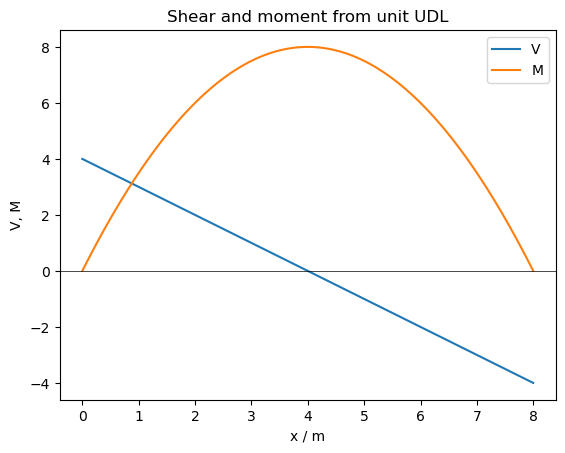

In [13]:
fig, ax = plt.subplots()

ax.plot(x11, V_1(x11, Q_(1, 'kN/m')).magnitude, label='V')
ax.plot(x11, M_1(x11, Q_(1, 'kN/m')).magnitude, label='M')
plt.axhline(y = 0, color = 'k', lw = 0.5)

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('V, M')
ax.legend()

plt.title('Shear and moment from unit UDL')
plt.savefig('ein-images/shear-moment-1.png')
plt.show

### 5.1.2 Point load at midspan

Add image

In [14]:
def V_2(x, P):
    """Return the shear at point x when loaded by point load P at midspan."""
    if isinstance(x.magnitude, np.ndarray):
        Vee = np.where( x < L / 2, P / 2, -P / 2 )
    else:
        if x < L / 2:
            Vee = P / 2
        elif x > L / 2:
            Vee = -P / 2
    return Vee

def M_2(x, P):
    """Return the bending moment at point x when loaded by point load P at midspan."""
    if isinstance(x.magnitude, np.ndarray):
        Emm = np.where( x < L / 2, P / 2 * x, P / 2 * ( L - x ) )
    else:
        if x < L / 2:
            Emm = P / 2 * x
        elif x > L / 2:
            Emm = P / 2 * ( L - x )
    return Emm

def Δ_2(x, P):
    """Return the deflection down at point x when loaded by point load P at midspan."""
    if isinstance(x.magnitude, np.ndarray):
        Delta = np.where( x < L / 2, P * x / ( 48 * E_c * I ) * ( 3 * L**2 - 4 * x**2 ),
                                     P * ( L - x ) / ( 48 * E_c * I ) * ( 3 * L**2 - 4 * (L - x )**2 ) )
    else:
        if x < L / 2:
            Delta = P * x / ( 48 * E_c * I ) * ( 3 * L**2 - 4 * x**2 )
        elif x > L / 2:
            Delta = P * ( L - x ) / ( 48 * E_c * I ) * ( 3 * L**2 - 4 * (L - x )**2 )
    return Delta

<function matplotlib.pyplot.show(close=None, block=None)>

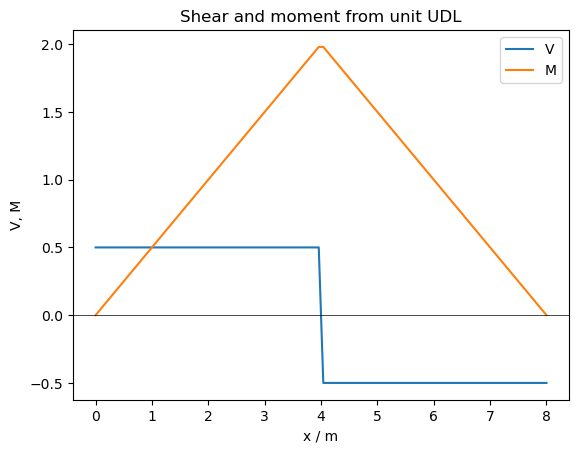

In [15]:
fig, ax = plt.subplots()

ax.plot(x11, V_2(x11, Q_(1, 'kN')).magnitude, label='V')
ax.plot(x11, M_2(x11, Q_(1, 'kN')).magnitude, label='M')
plt.axhline(y = 0, color = 'k', lw = 0.5)

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('V, M')
ax.legend()

plt.title('Shear and moment from unit midspan point load')
plt.savefig('ein-images/shear-moment-2.png')
plt.show

## 5.2 Applied loads

### 5.2.1 Self-weight

In [16]:
def V_SW(x):
    """Return the shear at point x from self-weight."""
    return V_1(x, w_SW)

def M_SW(x):
    """Return the shear at point x from self-weight."""
    return M_1(x, w_SW)

### 5.2.2 Live point load

In [17]:
def V_LL(x):
    """Return the shear at point x from point live load."""
    return V_2(x, P_LL)

def M_LL(x):
    """Return the shear at point x from point live load."""
    return M_2(x, P_LL)

## 5.3 Load effects

<function matplotlib.pyplot.show(close=None, block=None)>

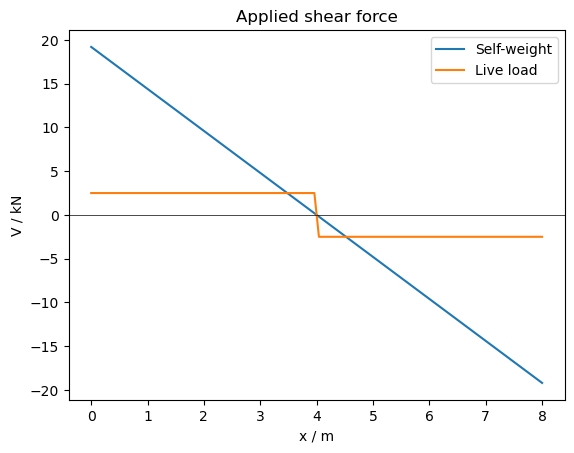

In [18]:
fig, ax = plt.subplots()

ax.plot(x11, V_SW(x11), label='Self-weight')
ax.plot(x11, V_LL(x11), label='Live load')
plt.axhline(y = 0, color = 'k', lw = 0.5)

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('V / kN')
ax.yaxis.set_units(ureg['kN'])
ax.legend()

plt.title('Applied shear force')
plt.savefig('ein-images/shear-1.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

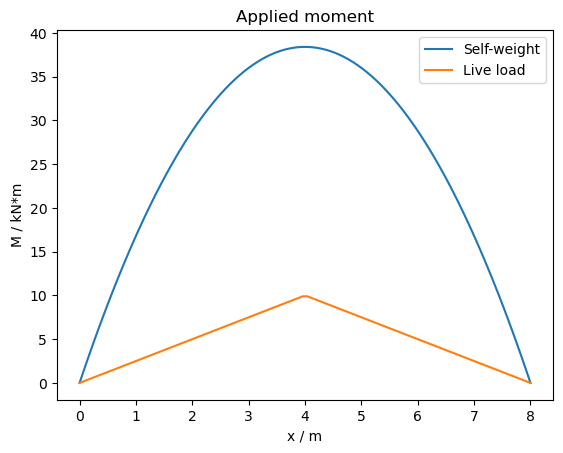

In [19]:
fig, ax = plt.subplots()

ax.plot(x11, M_SW(x11), label='Self-weight')
ax.plot(x11, M_LL(x11), label='Live load')

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('M / kN*m')
ax.yaxis.set_units(ureg['kN*m'])
ax.legend()

plt.title('Applied moment')
plt.savefig('ein-images/moment-1.png')
plt.show

# 6. Load Combinations

## 6.1 Load factors

In [20]:
α_D1_max = 1.10                 # S6:19 Tab. 3.3
α_D1_min = 0.95
α_D2_max = 1.20
α_D2_min = 0.90
α_D3_max = 1.25
α_D3_min = 0.80
α_D_ULS9 = 1.35                 # S6:19 Tab. 3.1

α_L_ULS1 = 1.70                 # S6:19 Tab. 3.2
α_L_SLS1 = 0.90                 # S6:19 Tab. 3.1

## 6.2 Ultimate limit states

In [21]:
def V_f_ULS1a(x):
    """Return shear at ULS1 with maximum load factors."""
    return α_D2_max * V_SW(x) + α_L_ULS1 * V_LL(x)

def M_f_ULS1a(x):
    """Return moment at ULS1 with maximum load factors."""
    return α_D2_max * M_SW(x) + α_L_ULS1 * M_LL(x)

def V_f_ULS9(x):
    """Return shear at ULS9 with maximum load factors."""
    return α_D_ULS9 * V_SW(x)

def M_f_ULS9(x):
    """Return moment at ULS9 with maximum load factors."""
    return α_D_ULS9 * M_SW(x)

In [22]:
def V_f_maxp(x):
    """Return greatest positive shear for all ULS combinations."""
    if isinstance(x.magnitude, np.ndarray):
        z = np.zeros(len(x)) * Q_(0, 'kN')
        Vf = V_f_ULS1a(x).to('kN'), V_f_ULS9(x).to('kN'), z
        return np.amax(Vf, axis=0) * Q_(1, 'kN')
    else:
        return max(V_f_ULS1a(x), V_f_ULS9(x), Q_(0, 'kN'))
    
def M_f_maxp(x):
    """Return greatest positive moment for all ULS combinations."""
    if isinstance(x.magnitude, np.ndarray):
        z = np.zeros(len(x)) * Q_(0, 'kN*m')
        Mf = M_f_ULS1a(x).to('kN*m'), M_f_ULS9(x).to('kN*m'), z
        return np.amax(Mf, axis=0)  * Q_(1, 'kN*m')
    else:
        return max(M_f_ULS1a(x), M_f_ULS9(x), Q_(0, 'kN*m'))
    
def V_f_maxn(x):
    """Return greatest negative shear for all ULS combinations."""
    if isinstance(x.magnitude, np.ndarray):
        z = np.zeros(len(x)) * Q_(0, 'kN')
        Vf = V_f_ULS1a(x).to('kN'), V_f_ULS9(x).to('kN'), z
        return np.amin(Vf, axis=0) * Q_(1, 'kN')
    else:
        return min(V_f_ULS1a(x), V_f_ULS9(x), Q_(0, 'kN'))
    
def M_f_maxn(x):
    """Return greatest negative moment for all ULS combinations."""
    if isinstance(x.magnitude, np.ndarray):
        z = np.zeros(len(x)) * Q_(0, 'kN*m')
        Mf = M_f_ULS1a(x).to('kN*m'), M_f_ULS9(x).to('kN*m'), z
        return np.amin(Mf, axis=0) *  Q_(1, 'kN*m')
    else:
        return min(M_f_ULS1a(x), M_f_ULS9(x), Q_(0, 'kN*m'))

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:86: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

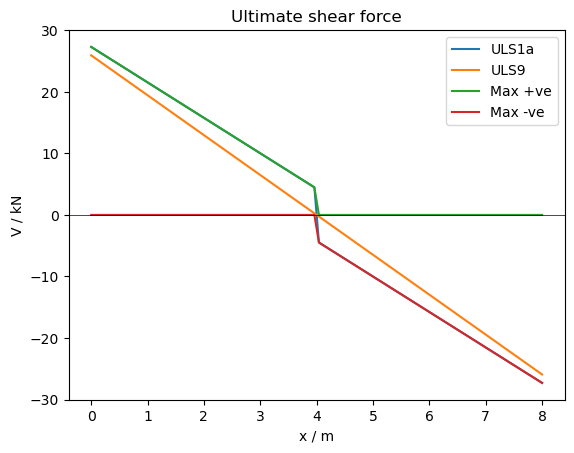

In [23]:
fig, ax = plt.subplots()

ax.plot(x11, V_f_ULS1a(x11), label='ULS1a')
ax.plot(x11, V_f_ULS9(x11), label='ULS9')
ax.plot(x11, V_f_maxp(x11), label='Max +ve')
ax.plot(x11, V_f_maxn(x11), label='Max -ve')
plt.axhline(y = Q_(0, 'kN'), color = 'k', lw = 0.5)

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('V / kN')
ax.yaxis.set_units(ureg['kN'])
ax.legend()

plt.title('Ultimate shear force')
plt.savefig('ein-images/shear-ULS-1.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

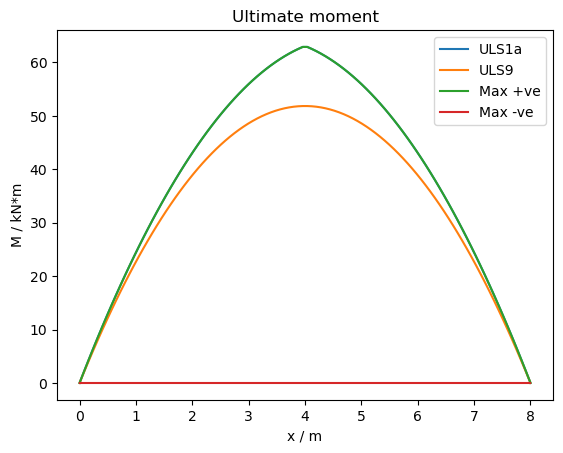

In [24]:
fig, ax = plt.subplots()

ax.plot(x11, M_f_ULS1a(x11), label='ULS1a')
ax.plot(x11, M_f_ULS9(x11), label='ULS9')
ax.plot(x11, M_f_maxp(x11), label='Max +ve')
ax.plot(x11, M_f_maxn(x11), label='Max -ve')

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('M / kN*m')
ax.yaxis.set_units(ureg['kN*m'])
ax.legend()

plt.title('Ultimate moment')
plt.savefig('ein-images/moment-ULS-1.png')
plt.show

## 6.3 Fatigue limit states

Not applicable

## 6.4 Serviceability limit states

In [25]:
def M_s(x):
    """Return moment at ULS1 with maximum load factors."""
    return M_SW(x) + α_ULS1_L * M_LL(x)

# 7. Ultimate Limit States Checks

## 7.1 Resistance factors

In [26]:
ϕ_c = 0.75                      # S6:19 Tab. 8.1
ϕ_s = 0.90                      # Greek phi symbol

## 7.2 Bending moment

In [27]:
a = ϕ_s * A_s * f_y / ( α_1 * ϕ_c * fprime_c * b )
M_r = ϕ_s * A_s * f_y * ( d - a / 2 )
M_r.ito('kN*m')
print(f'Moment resistance, {M_r=}')

Moment resistance, M_r=<Quantity(131.188841, 'kilonewton * meter')>


<function matplotlib.pyplot.show(close=None, block=None)>

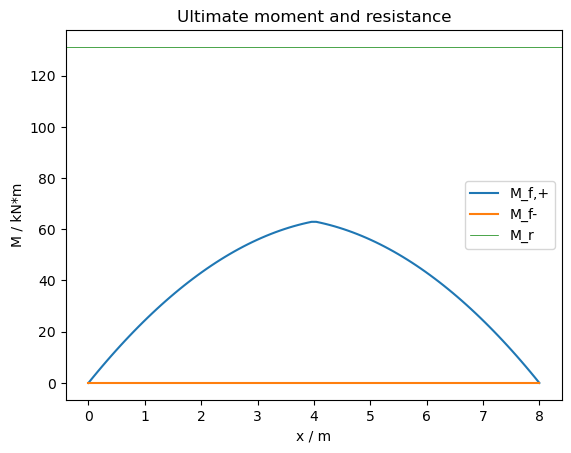

In [28]:
fig, ax = plt.subplots()

ax.plot(x11, M_f_maxp(x11), label='M_f,+')
ax.plot(x11, M_f_maxn(x11), label='M_f-')
plt.axhline(y = M_r, color = 'g', lw = 0.5, label='M_r')

plt.xlabel('x / m')
ax.xaxis.set_units(ureg['m'])
plt.ylabel('M / kN*m')
ax.yaxis.set_units(ureg['kN*m'])
ax.legend()

plt.title('Ultimate moment and resistance')
plt.savefig('ein-images/Mf-Mr-1.png')
plt.show

## 7.3 Shear

In [29]:
d_v = min



In [30]:
ϵ_x = 

θ =

SyntaxError: invalid syntax (3858123133.py, line 1)

In [ ]:
V_s =

V_c =

V_r = min

# 8. Serviceability Limit States Checks

## 8.1 Cracking

# 9. Other Checks

# 10. Conclusions